## Brain Tumor Binary Classification with Resnet

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.


## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
- Dataset Tree
    ```
        tumor
        ├─Training
        │ ├─glioma     : 1321 files
        │ ├─meningioma : 1339 files
        │ ├─notumor    : 1595 files
        │ └─pituitary  : 1457 files
        └─Testing
          ├─glioma     : 1321 files
          ├─meningioma : 1339 files
          ├─notumor    : 1595 files
          └─pituitary  : 1457 files
    ```
- Dataset Configuration
    - The number of images : 11424 files
    - The number of classes : 4
        - tumor, notumor
    - Average number of images per class : 2856 files/class

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/tumor/"

원본 데이터는 tumor가 3 class로 구성되어있습니다.
본 notebook에서는 이 데이터셋을 이용해 tumor가 있는지 없는지 판별하는 binary classification 문제로 재정의해서 문제를 풀려고 합니다. 문제의 요구사항에 따라 주어진 데이터셋을 재정리 할 필요가 있고 이를 구현하는 과정을 살펴봅시다.

이를 위해 4개의 class 를 2개의 binary class로 preprocessing 해줍니다. 4개의 multi-class classification 문제는 다른 notebook에서 확인해볼 수 있습니다.
```
    before = ['glioma', 'meningioma', 'notumor', 'pituitary']
    after = ['tumor', 'notumor']
```

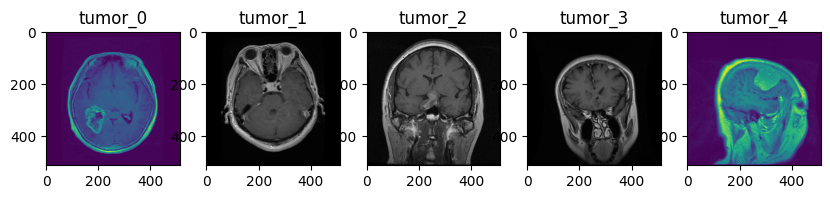

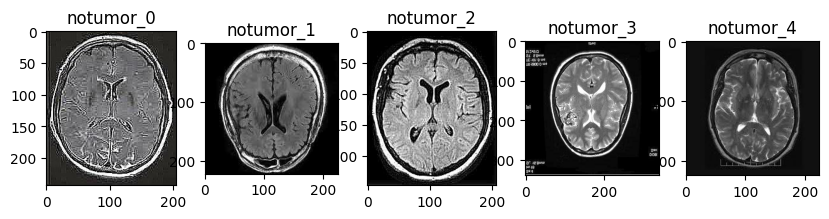

In [4]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

dir_main = "../../../data/tumor/"
classes_before = ['glioma', 'meningioma', 'notumor', 'pituitary']
classes = ['tumor', 'notumor']
source = "training"

def create_symlink(img_path, from_cls, to_cls):
    src = os.path.abspath(img_path)
    dst = src.replace(from_cls, to_cls)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        os.symlink(src, dst)

for img_path in glob(os.path.join(dir_main, f"*/*/*.jpg")):
    for from_cls in ['glioma', 'meningioma', 'pituitary']:
        if from_cls in img_path:
            create_symlink(img_path, from_cls, 'tumor')
            
image_paths = []
for cls in classes:
    image_paths.extend(glob(os.path.join(dir_main, source, f"{cls}/*.jpg")))

cls_image_paths = {}
n_show = 5
for cls in classes:
    cls_image_paths[cls] = [image_path for image_path in image_paths if cls == image_path.split("/")[-2]][:n_show]

for cls in classes:
    fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(10,2))
    for idx, image_path in enumerate(cls_image_paths[cls]):
        img = Image.open(image_path)
        axes[idx].set_title(f"{cls}_{idx}")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [9]:
import os
import numpy as np
from glob import glob
np.random.seed(724)

dir_main = "../../../data/tumor/"
classes = ['tumor', 'notumor']

def preprocessing(dir_name, classes):
    x_data = []
    for cls in classes:
        dir_data = os.path.join(dir_main, dir_name)
        x_data.extend(glob(f"{dir_data}/{cls}/*.jpg"))
    y_data = np.array([x.split("/")[-2] for x in x_data])
    return x_data, y_data

x_train, y_train = preprocessing("training", classes)
x_test, y_test = preprocessing("testing", classes)
x_val, y_val = preprocessing("testing", classes)

In [10]:
def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

tumor     	4117	906	906
notumor   	1595	405	405


### 2.4. Create DataLoader

In [20]:
import torch
from torch.utils.data import Dataset
from glob import glob

class TumorDataset(Dataset): 
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.classes = ['tumor', 'notumor']
        self.filelist = []
        for cls in self.classes:
            self.filelist.extend(glob(self.dir_dataset + f'/{cls}/*.jpg'))
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/cls/*.jpg'} is empty"
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename).convert("RGB")
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.FloatTensor)


    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [21]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
train_ds = TumorDataset(os.path.join(dir_main, "training"), train_tr)
val_ds = TumorDataset(os.path.join(dir_main, "testing"), test_tr)
test_ds = TumorDataset(os.path.join(dir_main, "testing"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - ResNet18

ResNet: Deep Residual Learning for Image Recognition ([Paper](https://arxiv.org/abs/1512.03385)) 이란?

ResNet18은 2015년 ImageNet Large Scale Visual Recognition Challenge (ILSVRC)에서 우승한 Residual Network (ResNet) 모델 중 하나입니다. ResNet은 딥러닝 모델의 깊이가 깊어짐에 따라 발생하는 Gradient Vanishing 문제를 해결하기 위한 구조로, 이전 모델들보다 훨씬 깊은 구조를 가졌습니다.

ResNet-18의 주요 특징은 다음과 같습니다.

1. Residual Block: ResNet은 Residual Block이라는 구조를 사용합니다. Residual Block은 입력값과 출력값을 더하는 Residual Connection을 가진 ResNet의 핵심 구조입니다. Residual Connection은 입력값이 직접 출력값에 더해져서, 모델의 더 깊은 부분에서 Gradient Vanishing 문제를 해결할 수 있습니다.

2. 18개의 Layer: ResNet-18은 Convolutional Neural Network (CNN)의 기본 구성인 Convolution, Batch Normalization, ReLU, Pooling 등의 레이어와 Residual Block을 18개의 레이어로 구성되어 있습니다. 따라서, 모델이 더 깊어질수록 연산량이 증가하지만 ResNet-18은 이전 모델들에 비해 훨씬 더 깊은 구조를 가졌으며, 이를 통해 더 나은 성능을 보여줍니다.

3. Pre-Activation Residual Block: ResNet-18에서는 Pre-Activation Residual Block이라는 구조를 사용합니다. 이 구조는 일반적인 Residual Block과 비슷하지만, Batch Normalization과 ReLU의 순서가 바뀌어, 모델의 학습을 더욱 효율적으로 할 수 있게 합니다.

4. Global Average Pooling: ResNet-18에서는 마지막 레이어에 Global Average Pooling을 사용합니다. 이를 통해, 마지막 Feature Map의 모든 위치에서의 정보를 평균내어 1차원 벡터로 만들어, 최종적인 분류를 수행합니다. 이는 Fully Connected Layer를 사용하는 것보다 파라미터 수를 줄이고, 모델의 Overfitting을 방지할 수 있습니다.

5. 다양한 데이터셋에서 우수한 성능: ResNet-18은 다양한 이미지 분류 데이터셋에서 우수한 성능을 보입니다. 예를 들어, ImageNet 데이터셋에서 Top-1 정확도는 69.8%, Top-5 정확도는 89.1%를 달성하였습니다. 또한, ResNet-18은 Transfer Learning에도 매우 유용하며, 다양한 분야에서도 높은 성능을 보여줍니다.

Resnet + 숫자의 숫자는 Residual Block 개수를 의미합니다. 이는 비슷한 아키텍쳐의 다른 사이즈 모델로 이해할 수 있습니다.
Resnet50과 Resnet18을 비교를 통해 이를 쉽게 이해할 수 있습니다.

1. ResNet-50과 ResNet-18은 모두 Residual Network (ResNet)의 일종으로, 딥러닝 모델의 깊이가 깊어짐에 따라 발생하는 Gradient Vanishing 문제를 해결하기 위한 구조로, 이전 모델들보다 훨씬 깊은 구조를 가졌습니다. 그러나 ResNet-50과 ResNet-18의 차이는 다음과 같습니다.

2. Layer 개수: ResNet-18은 Convolutional Neural Network (CNN)의 기본 구성인 Convolution, Batch Normalization, ReLU, Pooling 등의 레이어와 Residual Block을 18개의 레이어로 구성되어 있습니다. 반면, ResNet-50은 50개의 레이어로 구성되어 있습니다. 따라서, ResNet-50은 더 깊은 구조를 가지고 있어서, 더 복잡한 모델을 학습할 수 있습니다.

3. Residual Block의 구성: ResNet-50과 ResNet-18의 Residual Block은 비슷하지만, ResNet-50에서는 3x3 크기의 필터를 사용한 Convolution이 3개 연속으로 사용됩니다. 이를 BottleNeck Block이라고 부르며, 입력값과 출력값의 차원을 감소시키는 1x1 Convolution을 사용하여 연산량을 줄입니다. 또한, ResNet-50에서는 Residual Block마다 출력값의 차원을 두 배로 증가시키는 Downsample을 사용합니다.

4. 성능: ResNet-50은 ResNet-18보다 더 높은 성능을 보입니다. 예를 들어, ImageNet 데이터셋에서 Top-1 정확도는 76.15%, Top-5 정확도는 92.87%를 달성하였습니다. 이는 ResNet-18의 Top-1 정확도 69.8%, Top-5 정확도 89.1%보다 훨씬 우수합니다.

5. 메모리 사용량과 학습 속도: ResNet-50은 ResNet-18보다 더 많은 파라미터를 가지고 있어서, 더 많은 메모리를 사용합니다. 따라서, ResNet-50의 학습은 ResNet-18에 비해 더 오래 걸리고, 더 많은 컴퓨팅 자원이 필요합니다.

#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [22]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('resnet*', pretrained=True)

The number of pretrained models : 770


['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200d',
 'resnetaa50',
 'resnetblur50',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d_evos',
 'resnetv2_50d_gn',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152x2_bit_teacher',
 'resnetv2_152x2_bit_teacher_384',
 'resnetv2_152x2_bitm',
 'resnetv2_152x2_bitm_in21k',
 'resnetv2_152x4_bitm',
 'resnetv2_152x4_bitm_in21k']

In [23]:
model = timm.create_model('resnet18', pretrained=True)
model.default_cfg

{'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet18'}

In [24]:
model = timm.create_model('resnet18', pretrained=True, num_classes=len(classes), global_pool='avg')
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 2])

In [25]:
import timm
import torch.nn.functional as F
from torch import nn

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = ResNet18()
# to_device(model, device)

In [26]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.binary_cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [27]:
train_helper.evaluation(model, val_dl)

{'val_loss': 0.76919, 'val_acc': 0.31173}

## 4.Training

In [28]:
from tqdm import tqdm

epochs = 3
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 90/90 [09:37<00:00,  6.42s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.9687.pt
Epoch 0: train_loss: 0.3755, val_loss: 0.3464, val_acc: 0.9687


100%|██████████| 90/90 [09:26<00:00,  6.29s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.97842.pt
Epoch 1: train_loss: 0.3265, val_loss: 0.3341, val_acc: 0.9784


100%|██████████| 90/90 [10:08<00:00,  6.76s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.98656.pt
Epoch 2: train_loss: 0.3218, val_loss: 0.3292, val_acc: 0.9866


##### Train & Validation Losses

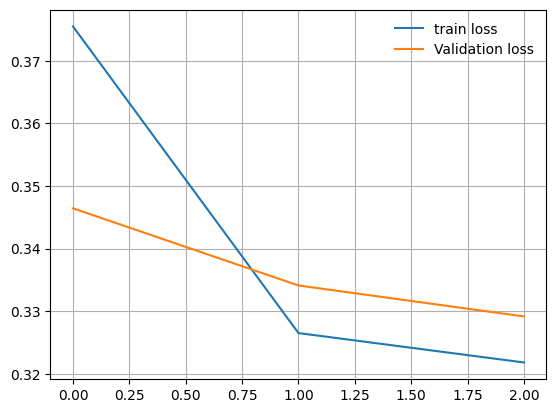

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

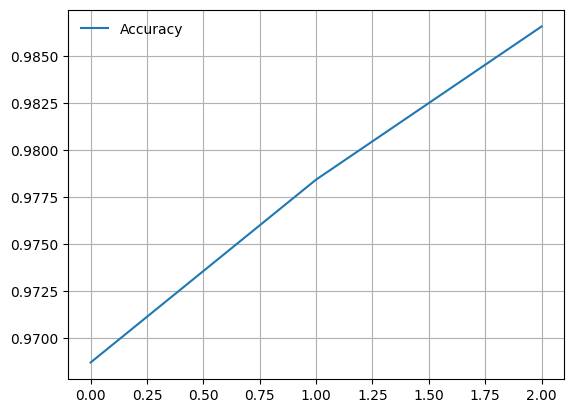

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

100%|██████████| 21/21 [00:27<00:00,  1.29s/it]

Classes : ['tumor', 'notumor']
Performance 
              precision    recall  f1-score   support

           0      0.996     0.986     0.991       906
           1      0.969     0.990     0.979       405

    accuracy                          0.987      1311
   macro avg      0.982     0.988     0.985      1311
weighted avg      0.987     0.987     0.987      1311



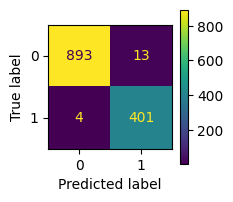

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    y_true.extend(torch.max(targets, dim=1)[1].numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [20]:
import torch

model=ResNet18()
model.load_state_dict(torch.load("./ckpt/best_ep_2_0.98656.pt", map_location='cpu'))

<All keys matched successfully>

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

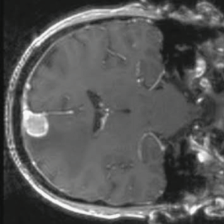

Prediction   : notumor (0.9465)
Ground Truth : tumor


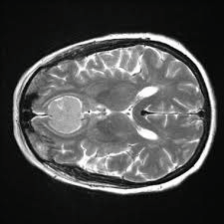

Prediction   : notumor (1.0000)
Ground Truth : tumor


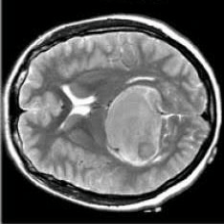

Prediction   : notumor (1.0000)
Ground Truth : tumor


In [32]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases (Low confidence, Edge case)

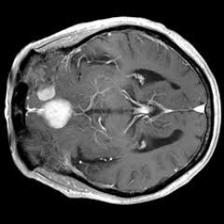

Prediction   : tumor (0.6873)
Ground Truth : tumor


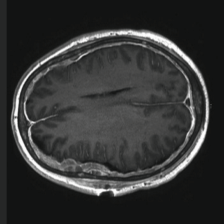

Prediction   : notumor (0.5866)
Ground Truth : notumor


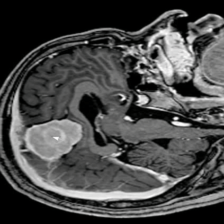

Prediction   : tumor (0.5999)
Ground Truth : tumor


In [34]:
TP = 3
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g and conf < 0.7:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1